# Segmenting cell images to aid in immunohistochemical analysis using LodeSTAR and iDISF
--- 

In this project we aim to use the image segmentation technique to identify cells that are
potentially carcinogenic on immunohistochemical exam image samples. We achieve this by using **LodeSTAR** network to detect such cells, and then
use the activation map of the model to generate scribbles for the [iDISF](https://github.com/IsabelaBB/iDISF) (Interactive Dynamic and 
Iterative Spanning Forest) segmentation tool. Our initial dataset is composed by 10 images collected from the PUC-Minas odontology laboratory.

## Initial Setup and imports

In [1]:
import sys
sys.path.append(".iDISF/python3/");
import os
import numpy as np
import matplotlib.pyplot as plt
from idisf import iDISF_scribbles
from PIL import Image

from simplification import get_ultimate_erosion, get_markers
from  prediction import load_model, get_prediction

/home/gustavo/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/gustavo/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/gustavo/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/gustavo/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/gustavo/.local/lib/python3.10/site-packages/deeptrack/backend/_config.py:11: UserWarning: cupy not insta

In [5]:
def visualize(figsize=(15, 15),**images):
    n = len(images)
    plt.figure(figsize=figsize)
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [3]:
def obtain_output_pil_image(label_arr):
    output_arr = np.where(label_arr == 1, 255, label_arr)
    output_arr = np.where(output_arr == 2, 0, output_arr)
    return Image.fromarray(output_arr).convert('L')

### Path Constants

In [2]:
INPUT_FOLDER = "./CellsDataset/original"
GROUND_TRUTH_FOLDER = "./CellsDataset/ground_truth"
MODEL_PATH = "./checkpoints/best.h5"

### Generating the segmentation
iDISF requires that the user draws scribbles to differentiate the background from the objects. In order to improve it's performance, we apply the ultimate erosion technique on the activation map, so that only the essential information of the objects is transformed into object scribble. The background scribbles are represented by the borders of the image.

In [4]:
def segment_cells_img(img, marker_img):
    # setting up iDISF parameters
    n0 = 0
    iterations = 1
    f = 1
    c1 = 0.1
    c2 = 0.1
    segm_method = 1
    all_borders = 1
    
    # applying ultimate erosion to simplify the objects on the activations image
    simplified_marker_img = get_ultimate_erosion(marker_img)

    # generating scribbles for iDISF
    num_obj, markers_coords, scribbles_sizes = get_markers(simplified_marker_img)
    
    # returning the segmentation and the borders
    return iDISF_scribbles(
        img, n0, iterations, np.array(markers_coords), np.array(scribbles_sizes), num_obj, f, c1, c2, segm_method, all_borders)

Loading the LodeSTAR weights.

In [6]:
model = load_model(MODEL_PATH)

In [7]:
segmentations = []
original_images = []
ground_truth = []

Obtaining the activations and then segmenting.

In [8]:
for complete_filename in os.listdir(INPUT_FOLDER):
    filename, extension = os.path.splitext(complete_filename)
    input_img_path = INPUT_FOLDER + "/" + filename + extension
    gt_img_path = GROUND_TRUTH_FOLDER + "/" + filename + ".png" 
    gt_img = Image.open(gt_img_path)
    
    # Obtaining the activations to make the markers
    original, activations_img = get_prediction(input_img_path, model)
    
    # Segmenting the images from the activations
    labels_arr, borders_arr = segment_cells_img(np.asarray(original), np.asarray(activations_img))
    
    segmentation = obtain_output_pil_image(labels_arr)

    segmentations.append(segmentation)
    original_images.append(original)
    ground_truth.append(gt_img)

2023-08-08 16:06:50.619387: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 401604608 exceeds 10% of free system memory.
2023-08-08 16:06:50.813490: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 401604608 exceeds 10% of free system memory.
2023-08-08 16:06:51.572649: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 200802304 exceeds 10% of free system memory.
2023-08-08 16:06:51.720363: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 200802304 exceeds 10% of free system memory.
2023-08-08 16:06:52.036494: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 200802304 exceeds 10% of free system memory.


1/1 [==============================] - 5s 5s/step


### Visualizing the results

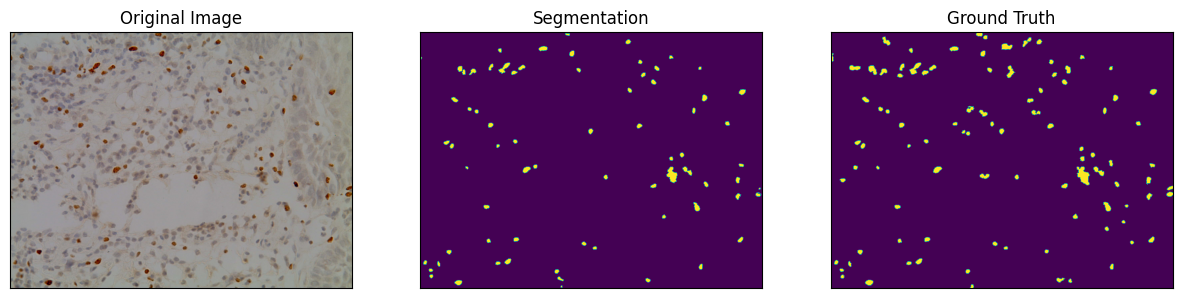

In [12]:
index = 8
visualize(original_image = original_images[index], segmentation = segmentations[index], ground_truth = ground_truth[index].convert('L'))